In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
import os

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_context('notebook')
import corner


from agnfinder.prospector.main import load_catalog
from agnfinder.prospector import load_photometry
from agnfinder import simulation_samples, simulation_utils

In [10]:
catalog_loc = '/media/mike/beta/agnfinder/cpz_paper_sample_week3.parquet'
catalog = load_catalog(catalog_loc)

In [3]:
os.chdir('/home/mike/repos/agnfinder')
grid_loc = 'data/photometry_simulation_100000.hdf5'

In [4]:
assert os.path.isfile(grid_loc)
with h5py.File(grid_loc, 'r') as f:
    param_names = f['samples']['theta'].attrs['columns']  # stored as "attribute" metadata
    norm_theta = f['samples']['normalised_theta'][...]
    theta = f['samples']['theta'][...]
    simulated_y = f['samples']['simulated_y'][...]
    wavelengths = f['samples']['wavelengths'][...]

In [34]:
output_dim = 7
n_galaxies = 5000

In [39]:
best_thetas = np.zeros((n_galaxies, output_dim))
best_norm_theta = np.zeros((n_galaxies, output_dim))
for n in range(n_galaxies):  # could probably do in one go if this is slow
    _, photometry, _ = load_photometry.load_maggies_from_galaxy(catalog.sample().squeeze(), reliable=True)
    error = np.sum((photometry - simulated_y) ** 2, axis=1)
    best_params_index = np.argmin(error) # equivalent to an MLE in discrete space
    best_thetas[n] = theta[best_params_index]
    best_norm_theta[n] = norm_theta[best_params_index]


<Figure size 432x288 with 0 Axes>

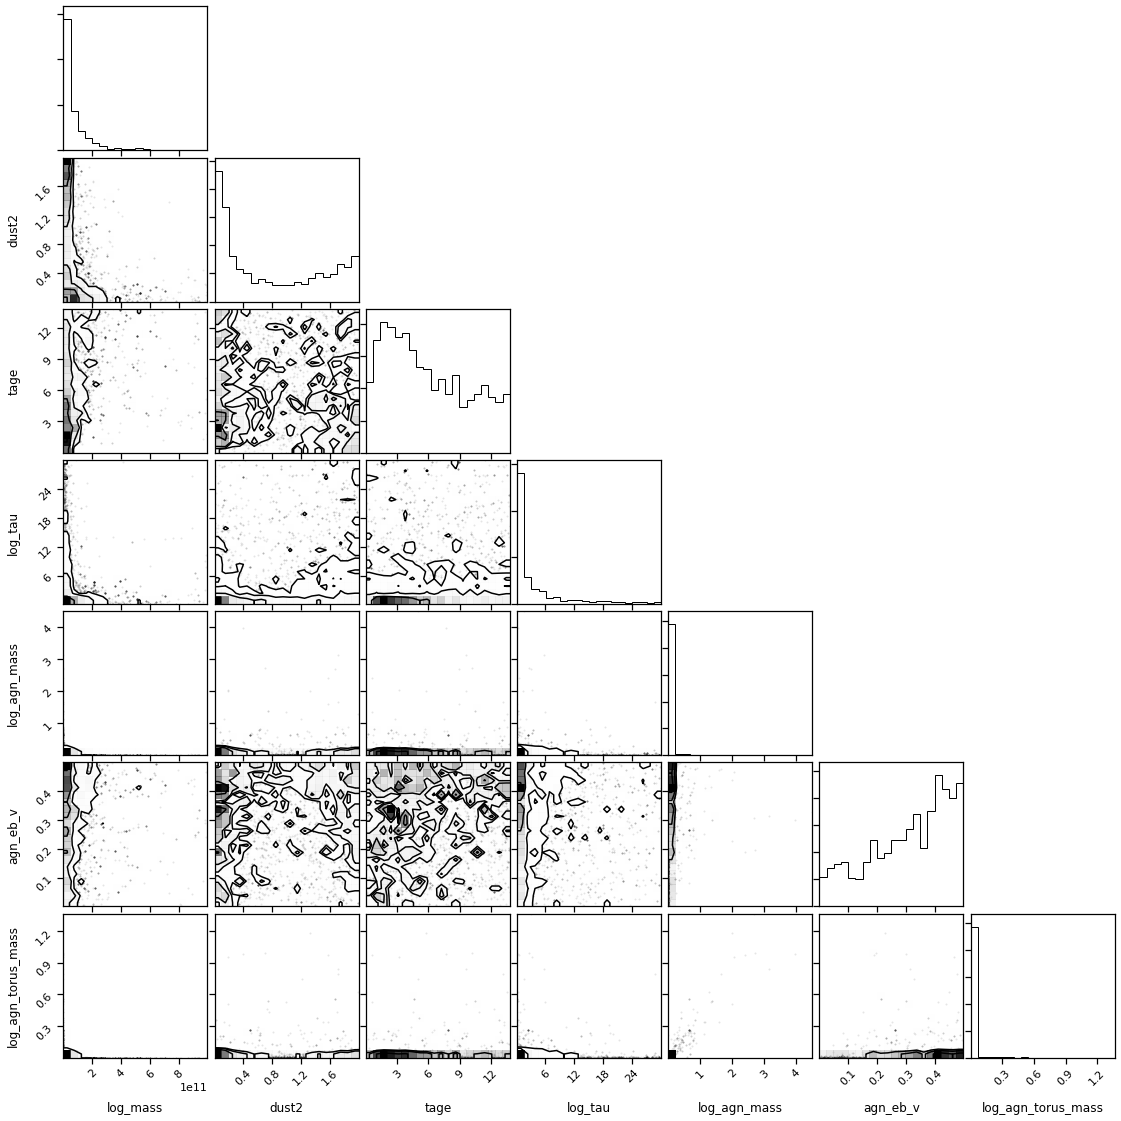

In [40]:

plt.figure()
_ = corner.corner(best_thetas, labels=param_names)
plt.savefig('best_theta_random_5k.pdf')

<Figure size 432x288 with 0 Axes>

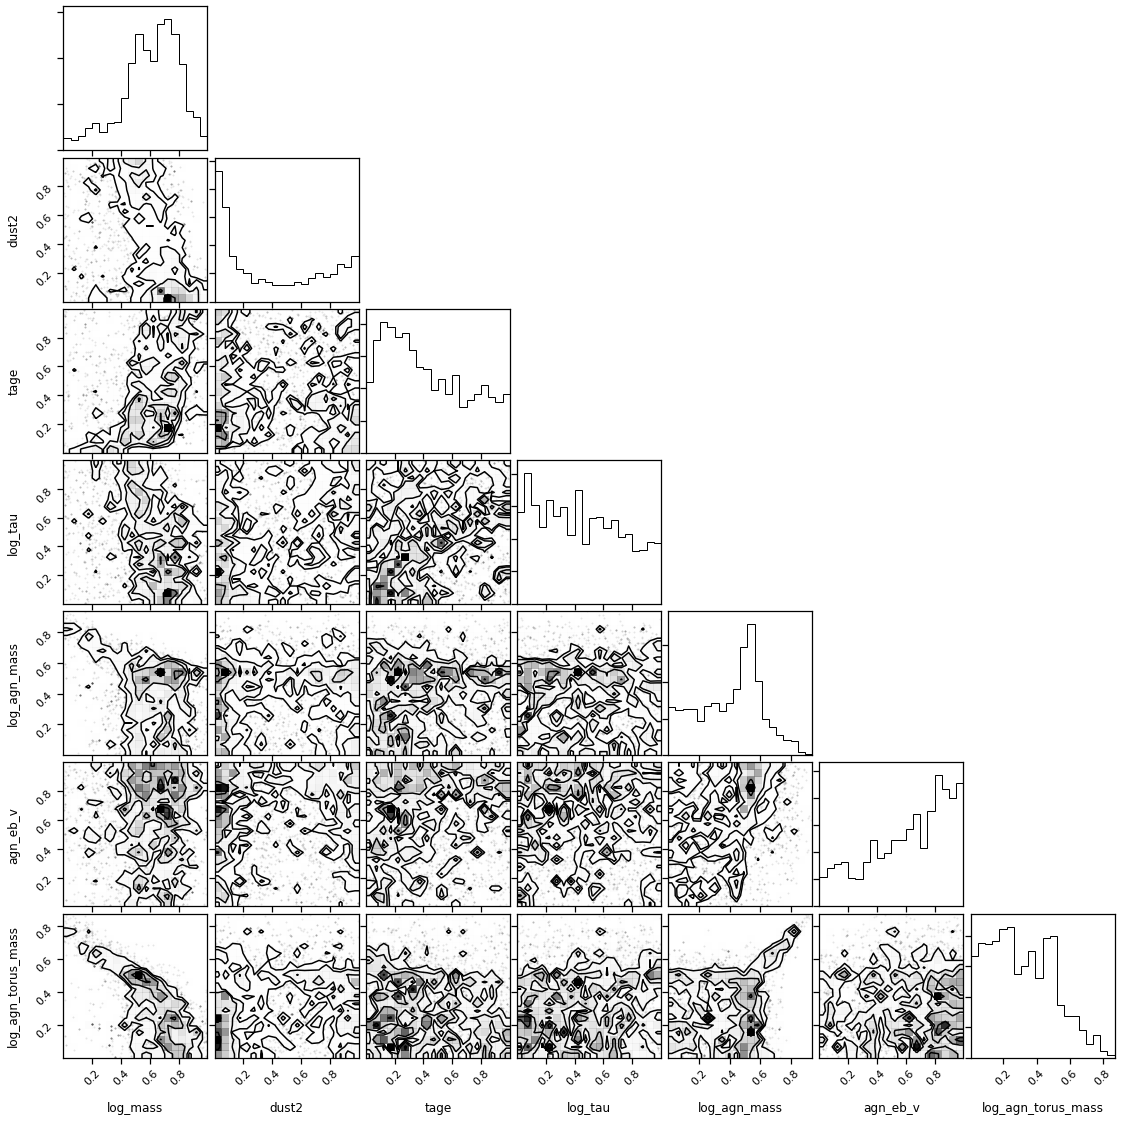

In [41]:

plt.figure()
_ = corner.corner(best_norm_theta, labels=param_names)
plt.savefig('best_norm_theta_random_5k.pdf')